# Domain: Industrial Safety Support 
# NLP based ChatBot - Safex Pybot



#### CONTEXT:
The database comes from one of the biggest industry in Brazil and in the world. It is an urgent need for industries/companies around the
globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.
#### DATA DESCRIPTION:
This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an occurrence of an accident.
#### Columns description:
‣ Data: timestamp or time/date information

‣ Countries: which country the accident occurred (anonymised)

‣ Local: the city where the manufacturing plant is located (anonymised)

‣ Industry sector: which sector the plant belongs to

‣ Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)

‣ Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)

‣ Genre: if the person is male of female

‣ Employee or Third Party: if the injured person is an employee or a third party

‣ Critical Risk: some description of the risk involved in the accident

‣ Description: Detailed description of how the accident happened.

Link to download the dataset: https://www.kaggle.com/ihmstefanini/industrial-safety-and-health-analytics-database [ for your reference only ]

####  PROJECT OBJECTIVE:
Design a ML/DL based chatbot utility which can help the professionals to highlight the safety risk as per the incident description.

In [46]:
#Importing the data and files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats; from scipy.stats import zscore, norm, randint
import pickle
import warnings
warnings.filterwarnings("ignore")

In [47]:
# import the libraries

import nltk
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()

# things we need for Tensorflow

import tensorflow as tf
import tflearn
import random

In [48]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Variable to handle model training

In [1]:
use_pretrained_model=True

### Modeling and functions for Question and Answers

In [50]:
# import our chat-bot intents file
import json
with open('safexpybot_intents_qna.json') as json_data:
    intents = json.load(json_data)
    

In [51]:
# Initialize data fields for our file

words = []
classes = []
documents = []
ignore_words = ['?']
# loop through each sentence in our intents patterns
for intent in intents['intents']:
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = nltk.word_tokenize(pattern)
        # add to our words list
        words.extend(w)
        # add to documents in our corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

# stem and lower each word and remove duplicates
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

# remove duplicates
classes = sorted(list(set(classes)))


In [52]:
# create our training data
training = []
output = []
# create an empty array for our output
output_empty = [0] * len(classes)

# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # stem each word
    pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]
    # create our bag of words array
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)

# create train and test lists
X_train = list(training[:,0])
y_train = list(training[:,1])

In [56]:
# reset underlying graph data
from tensorflow.python.framework import ops
ops.reset_default_graph()
    
    # Build neural network
net_qna = tflearn.input_data(shape=[None, len(X_train[0])])
net_qna = tflearn.fully_connected(net_qna, 16)
net_qna = tflearn.fully_connected(net_qna, 16)
net_qna = tflearn.fully_connected(net_qna, len(y_train[0]), activation='softmax')
net_qna = tflearn.regression(net_qna)

# Define model and setup tensorboard
model_qna = tflearn.DNN(net_qna, tensorboard_dir='tflearn_logs')

if use_pretrained_model==False:
    # Start training (apply gradient descent algorithm)
    model_qna.fit(X_train, y_train, n_epoch=1000, batch_size=8, show_metric=True)
    model_qna.save('model_qna.tflearn')
    
    pickle.dump( {'words':words, 'classes':classes, 'X_train':X_train, 'y_train':y_train}, open( "qna_training_data", "wb" ) )

Training Step: 17999  | total loss: 0.89035 | time: 0.086s
| Adam | epoch: 1000 | loss: 0.89035 - acc: 0.8707 -- iter: 136/143
Training Step: 18000  | total loss: 0.81619 | time: 0.090s
| Adam | epoch: 1000 | loss: 0.81619 - acc: 0.8711 -- iter: 143/143
--
INFO:tensorflow:C:\Users\Dell\Desktop\GreatLearning PGP AIML\Capstone Project\Final Capstone Project\model_qna.tflearn is not in all_model_checkpoint_paths. Manually adding it.


In [57]:
# restore all of our data structures
import pickle
data_qna = pickle.load( open( "qna_training_data", "rb" ) )
words_qna = data_qna['words']
classes_qna = data_qna['classes']
X_train_qna = data_qna['X_train']
y_train_qna = data_qna['y_train']

# import our chat-bot intents file
import json
with open('safexpybot_intents_qna.json') as json_data:
    intents_qna = json.load(json_data)

In [58]:
# load our saved model
#if use_pretrained_model==True:
model_qna.load('./model_qna.tflearn')

INFO:tensorflow:Restoring parameters from C:\Users\Dell\Desktop\GreatLearning PGP AIML\Capstone Project\Final Capstone Project\model_qna.tflearn


In [59]:
# functions for cleansing the sentenses and to get the bag of words

def clean_up_sentence(sentence):
    # tokenize the pattern
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word
    sentence_words = [stemmer.stem(word.lower()) for word in sentence_words]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence
def bow(sentence, words, show_details=False):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words
    bag = [0]*len(words)  
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)

    return(np.array(bag))

### Response and Classify function for Question and Answer Chatbot

In [60]:
# functions to classify the sentences and for respective responses
# create a data structure to hold user context

context = {}

ERROR_THRESHOLD = 0.25
def classify(sentence):
    # generate probabilities from the model
    results = model_qna.predict([bow(sentence, words_qna)])[0]
    # filter out predictions below a threshold
    results = [[i,r] for i,r in enumerate(results) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append((classes_qna[r[0]], r[1]))
    # return tuple of intent and probability
    return return_list


def response(sentence, show_details=False):
    results = classify(sentence)
    # if we have a classification then find the matching intent tag
    if results:
        # loop as long as there are matches to process
        while results:
            for i in intents_qna['intents']:
                # find a tag matching the first result
                if i['tag'] == results[0][0]:
                    # a random response from the intent
                    return print('BOT: ', random.choice(i['responses']))

            results.pop(0)
            

## Chatbot : Historical Data Insights

In [61]:
dataset= pd.read_csv('data.csv')
#print("Shape of the dataset is :",dataset.shape)
#dataset.head()

Creating a list of possible features allowed for showing the data insights

In [62]:
dataset_features=['Country', 'Local', 'Industry Sector', 'Accident Level',
       'Potential Accident Level', 'Gender', 'Natureofemployee','Year','Local','Season']

### Function to be called by the Chatbot for showing data insights

In [63]:
def show_eda(response_result):
    eda_flag = True
    result = list(response_result.split(","))
    result_items = len(result)
    
    for item in result:
        if item not in dataset_features:
            eda_flag = False
    
    if eda_flag == True:
        if result_items == 1:
            univariate_analysis_categorical(dataset,result[0])
        elif result_items == 2:
           
            bivariate_analysis_categorical(dataset,result[0],result[1])
        else:
            print("Sorry, not able to find appropriate answer. Please ask teh question again")
    else:
        print(response_result)  
        
        
            
    

In [64]:
def univariate_analysis_categorical(dataset,feature):    
    print("\n")
    print("===========================================================================================")
    print("Data Analysis of feature: ",feature)
    print("===========================================================================================\n")
                
    print("\n")  
    print("-----------------")
    print("Countplot  for feature: ",feature)
    print("-----------------")
        
    plt.figure(figsize=(10,6))
    sns.countplot(dataset[feature],order = dataset[feature].value_counts().index)
    plt.xticks(rotation = 'vertical')
    plt.show()
    
    print("-----------------")
    print("Pie Chart for feature: ",feature)
    print("------------------")      
        
    labels=dataset[feature].unique()
    plt.figure(figsize=(10,6))
    dataset[feature].value_counts().plot.pie(autopct="%.1f%%")
    plt.show()
            
    
    print("\n")
    print("-----------------")
    print("Value Counts for feature: ",feature)
    print("-------------------")
    
    print(dataset[feature].value_counts().sort_values(ascending=False))
    print('')

In [65]:
def bivariate_analysis_categorical(dataset,feature1,feature2):
    
       
            if feature1 != feature2:              
                   

                print("\n")
                print("===========================================================================================")
                print("Data Analysis of features: ",feature1,' and  ', feature2)
                print("===========================================================================================")

                
                bivariate_analysis_df = pd.crosstab(index=dataset[feature1], 
                                          columns=dataset[feature2])
                
                print("\n")
                print("------------------------------------------")
                print("Cross table Analysis of features: ",feature1,' and  ', feature2)
                print("------------------------------------------")
                
                display(bivariate_analysis_df)
                
                print("\n")
                print("------------------------------------------")
                print("Count plot Analysis of features: ",feature1,' and  ', feature2)
                print("------------------------------------------")
                
                plt.figure(figsize=(12,6))
                sns.countplot(x=feature1, hue=feature2, data=dataset)
                plt.show()
                



## Modeling and Functions for Historical Data Insights through chatbot

In [66]:
# import our chat-bot intents file
import json
with open('safexpybot_intents_eda.json') as json_data:
    intents_eda = json.load(json_data)

# Initialize data fields for our file

words = []
classes = []
documents = []
ignore_words = ['?']
# loop through each sentence in our intents patterns
for intent in intents_eda['intents']:
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = nltk.word_tokenize(pattern)
        # add to our words list
        words.extend(w)
        # add to documents in our corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

# stem and lower each word and remove duplicates
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

# remove duplicates
classes = sorted(list(set(classes)))

#print (len(documents), "documents")
#print (len(classes), "classes", classes)
#print (len(words), "unique stemmed words", words)


# create our training data
training = []
output = []
# create an empty array for our output
output_empty = [0] * len(classes)

# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # stem each word
    pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]
    # create our bag of words array
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)

# create train and test lists
X_train = list(training[:,0])
y_train = list(training[:,1])


# reset underlying graph data
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Build neural network
net_eda = tflearn.input_data(shape=[None, len(X_train[0])])
net_eda = tflearn.fully_connected(net_eda, 16)
net_eda = tflearn.fully_connected(net_eda, 16)
net_eda = tflearn.fully_connected(net_eda, len(y_train[0]), activation='softmax')
net_eda = tflearn.regression(net_eda)

# Define model and setup tensorboard
model_eda = tflearn.DNN(net_eda, tensorboard_dir='tflearn_logs')

if use_pretrained_model==False:
    # Start training (apply gradient descent algorithm)
    model_eda.fit(X_train, y_train, n_epoch=1000, batch_size=8, show_metric=True)
    model_eda.save('model_eda.tflearn')
    pickle.dump( {'words':words, 'classes':classes, 'X_train':X_train, 'y_train':y_train}, open( "eda_training_data", "wb" ) )


Training Step: 14999  | total loss: 0.10880 | time: 0.058s
| Adam | epoch: 1000 | loss: 0.10880 - acc: 0.9851 -- iter: 112/113
Training Step: 15000  | total loss: 0.09793 | time: 0.064s
| Adam | epoch: 1000 | loss: 0.09793 - acc: 0.9866 -- iter: 113/113
--
INFO:tensorflow:C:\Users\Dell\Desktop\GreatLearning PGP AIML\Capstone Project\Final Capstone Project\model_eda.tflearn is not in all_model_checkpoint_paths. Manually adding it.


In [67]:
# restore all of our data structures
import pickle
data_eda = pickle.load( open( "eda_training_data", "rb" ) )
words_eda = data_eda['words']
classes_eda = data_eda['classes']
X_train_eda = data_eda['X_train']
y_train_eda = data_eda['y_train']


In [68]:
# import our chat-bot intents file
import json
with open('safexpybot_intents_eda.json') as json_data:
    intents_eda = json.load(json_data)

#if use_pretrained_model==True:
# load our saved model
model_eda.load('./model_eda.tflearn')

INFO:tensorflow:Restoring parameters from C:\Users\Dell\Desktop\GreatLearning PGP AIML\Capstone Project\Final Capstone Project\model_eda.tflearn


### Response and Classify function for Historical Data Insights

In [69]:

# functions to classify the sentences and for respective responses
# create a data structure to hold user context

context = {}

ERROR_THRESHOLD = 0.25
def classify_eda(sentence):
    # generate probabilities from the model
    results = model_eda.predict([bow(sentence, words_eda)])[0]
    # filter out predictions below a threshold
    results = [[i,r] for i,r in enumerate(results) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append((classes_eda[r[0]], r[1]))
    # return tuple of intent and probability
    return return_list


def response_eda(sentence, show_details=False):
    
    results = classify_eda(sentence)
    
    # if we have a classification then find the matching intent tag
    if results:
        # loop as long as there are matches to process
        while results:
            for i in intents_eda['intents']:
                
                # find a tag matching the first result
                if i['tag'] == results[0][0]:
                    
                    #return print(random.choice(i['responses']))
                    response_result = random.choice(i['responses'])
                    show_eda(response_result)
                    

            results.pop(0)
            

In [70]:
#print(response_eda('analysis for Accident'))

## Chatbot : Classification Model

In [71]:
dataset_clf = dataset.copy()

In [72]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
#from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import string
nltk.download('stopwords')
stop=set(stopwords.words('english'))

def preprocess_text(text):
      corpus=[]
      #stem=PorterStemmer()
      lem=WordNetLemmatizer()
      for news in text:
          words=[w for w in word_tokenize(news) if (w not in stop)]
          
          words=[lem.lemmatize(w) for w in words if len(w)>2]
          words = [''.join(c for c in s if c not in string.punctuation) for s in words if s]
          words = [word.lower() for word in words]
          words = [word for word in words if word.isalpha()]
          corpus.append(words) 
         
      return corpus      
      
dataset_clf['processed_text']= preprocess_text(dataset_clf['Description'])

desc_processed = []
for i in range(len(dataset_clf['processed_text'])):
   desc_processed.append(' '.join(wrd for wrd in dataset_clf.iloc[:,14][i]))

dataset_clf['description_processed'] = desc_processed


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Modeling and functions for  Accident Level

In [73]:
#Count vectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X = dataset_clf['description_processed']
y = dataset_clf['Accident Level']

vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
Xc = vectorizer.fit_transform(X).toarray()
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, y, test_size=0.15, random_state=42)

In [74]:
#SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC

svc = LinearSVC( max_iter=2500)
if use_pretrained_model==False:
    svc.fit(Xc_train, yc_train)
    yc_pred_SVC = svc.predict(Xc_test)
    acc_svc = accuracy_score(yc_test, yc_pred_SVC)
    acc_svc_tr = svc.score(Xc_train, yc_train)
    print('\n')
    print("Train accuracy of the SVC model : {:.2f}".format(acc_svc_tr*100))
    print('\n')
    print("Test accuracy of the SVC model : {:.2f}".format(acc_svc*100))
    print('\n')
    print('Classification report:',classification_report(yc_test, yc_pred_SVC))
    # save the model
    filename = 'svc_model_acclevel.sav'
    pickle.dump(svc, open(filename, 'wb'))



Train accuracy of the SVC model : 99.44


Test accuracy of the SVC model : 79.37


Classification report:               precision    recall  f1-score   support

           I       0.80      1.00      0.89        48
          II       0.00      0.00      0.00         5
         III       1.00      0.25      0.40         4
          IV       1.00      0.20      0.33         5
           V       0.00      0.00      0.00         1

    accuracy                           0.79        63
   macro avg       0.56      0.29      0.32        63
weighted avg       0.75      0.79      0.73        63



In [75]:
loaded_model_acclevel = pickle.load(open('./svc_model_acclevel.sav', 'rb'))

#### Reponse function for Accident Level Predictor chatbot

In [76]:
def response_acclevel(sentence):
    
    df_user_input=pd.DataFrame()
    df=pd.DataFrame()
    user_input = {'Description': sentence}
    df_user_input = df_user_input.append(user_input, ignore_index = True)
    df_user_input['processed_text']= preprocess_text(df_user_input['Description'])
    df['processed_text']=df_user_input['processed_text']
    df.reset_index(inplace=True)
    desc_processed = []
    for i in range(len(df['processed_text'])):
        desc_processed.append(' '.join(wrd for wrd in df.iloc[:,1][i]))
    test = vectorizer.transform(desc_processed)
    result = loaded_model_acclevel.predict(test)
    return result
    

### Modeling and functions for Potential Accident Level

In [77]:
#Count vectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X = dataset_clf['description_processed']
y = dataset_clf['Potential Accident Level']

vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
Xc = vectorizer.fit_transform(X).toarray()
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, y, test_size=0.15, random_state=42)

In [78]:
#SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC

svc_potacclevel = LinearSVC( max_iter=2500)
if use_pretrained_model==False:
    svc_potacclevel.fit(Xc_train, yc_train)
    yc_pred_SVC_potacclevel = svc_potacclevel.predict(Xc_test)
    acc_svc_potacclevel = accuracy_score(yc_test, yc_pred_SVC_potacclevel)
    acc_svc_tr_potacclevel = svc.score(Xc_train, yc_train)
    print('\n')
    print("Train accuracy of the SVC model : {:.2f}".format(acc_svc_tr_potacclevel*100))
    print('\n')
    print("Test accuracy of the SVC model : {:.2f}".format(acc_svc_potacclevel*100))
    print('\n')
    print('Classification report:',classification_report(yc_test, yc_pred_SVC_potacclevel))
    #save the model
    filename = 'svc_model_potacclevel.sav'
    pickle.dump(svc_potacclevel, open(filename, 'wb'))



Train accuracy of the SVC model : 19.44


Test accuracy of the SVC model : 46.03


Classification report:               precision    recall  f1-score   support

           I       1.00      0.14      0.25         7
          II       0.43      0.55      0.48        11
         III       0.35      0.32      0.33        19
          IV       0.52      0.70      0.59        23
           V       0.00      0.00      0.00         3

    accuracy                           0.46        63
   macro avg       0.46      0.34      0.33        63
weighted avg       0.48      0.46      0.43        63



In [79]:
loaded_model_potacclevel = pickle.load(open('./svc_model_potacclevel.sav', 'rb'))

#### Reponse function for Potential Accident Level Predictor chatbot

In [80]:
def response_potacclevel(sentence):
    
    df_user_input=pd.DataFrame()
    df=pd.DataFrame()
    user_input = {'Description': sentence}
    df_user_input = df_user_input.append(user_input, ignore_index = True)
    df_user_input['processed_text']= preprocess_text(df_user_input['Description'])
    df['processed_text']=df_user_input['processed_text']
    df.reset_index(inplace=True)
    
    desc_processed = []
    for i in range(len(df['processed_text'])):
        desc_processed.append(' '.join(wrd for wrd in df.iloc[:,1][i]))
    test = vectorizer.transform(desc_processed)
    result = loaded_model_potacclevel.predict(test)
    return result
    

## Chatbot with Conditions

### Chatbot function for Question and Answers

In [81]:
def chatbot_qna():
    flag=True
    print('\n')
    print("BOT: I am your Virtual assistant. I will try to answer your questions on Accidents Data! \
    \n \t If you want to exit any time, just type Bye!")
    while(flag==True):
        print('\n')
        user_response = input("You: ")
        user_response=user_response.lower()
        if(user_response!='bye') and (user_response!='exit') and (user_response!='quit'):
            if(user_response=='thanks' or user_response=='thank you' ):
                flag=False
                print('\n')
                print("BOT: You are welcome..")
                print("BOT: Exited from Question and Answer Module")

            else:
                print('\n')
                response(user_response)
                print('\n')
        else:
            flag=False
            print('\n')
            print("BOT: Exited from Question and Answer Module")
            #print("BOT: Goodbye! Take care  ")
            print('\n')
            print('-----------------------------------------------------')
            print('\n')
            

### Chatbot function for Accident Level Classification

In [82]:
def chatbot_acclevel():
    flag=True
    print('\n')
    print("BOT: I am your Virtual assistant. I will try to Predict Accident Level for your description \
    \n \t If you want to exit any time, just type Bye!")
    while(flag==True):
        print('\n')
        user_response = input("You: ")
        user_response=user_response.lower()
        if(user_response!='bye') and (user_response!='exit') and (user_response!='quit'):
            if(user_response=='thanks' or user_response=='thank you' ):
                flag=False
                print('\n')
                print("BOT: You are welcome..")
                print("BOT: Exited from Accident Level Predictor")

            else:
                print('\n')
                response = response_acclevel(user_response)
                
                if response:
                    print ("Bot: Accident Level is --> ",response[0])
                print('\n')
        else:
            flag=False
            print('\n')
            print("BOT: Exited from Accident Level Predictor Module")
            #print("BOT: Goodbye! Take care  ")
            print('\n')
            print('-----------------------------------------------------')
            print('\n')

### Chatbot function for Potential Accident Level Classification

In [83]:
def chatbot_potacclevel():
    flag=True
    print('\n')
    print("BOT: I am your Virtual assistant. I will try to predict Potential Accident Level for your description \
    \n \t If you want to exit any time, just type Bye!")
    while(flag==True):
        print('\n')
        user_response = input("You: ")
        user_response=user_response.lower()
        if(user_response!='bye') and (user_response!='exit') and (user_response!='quit'):
            if(user_response=='thanks' or user_response=='thank you' ):
                flag=False
                print('\n')
                print("BOT: You are welcome..")
                print("BOT: Exited from Potential Accident Level Predictor")

            else:
                print('\n')
                response = response_potacclevel(user_response)
                
                if response:
                    print ("Bot: Potential Accident Level is --> ",response[0])
                print('\n')
        else:
            flag=False
            print('\n')
            print("BOT: Exited from Potential Accident Level Predictor Module")
            #print("BOT: Goodbye! Take care  ")
            print('\n')
            print('-----------------------------------------------------')
            print('\n')

### Chat bot function for showing Historical Data Insights

In [84]:
def chatbot_eda():
    flag=True
    print('\n')
    print("BOT: I am your Virtual assistant. I will help you with Insights of Accident Historical Data! \
          \n \t If you want to exit any time, just type Bye!")
    while(flag==True):
        
        print('\n')
        user_response = input("You: ")
        user_response=user_response.lower()
        if(user_response!='bye') and (user_response!='exit') and (user_response!='quit'):
            if(user_response=='thanks' or user_response=='thank you' ):
                flag=False
                print('\n')
                print("BOT: You are welcome..")
                print("BOT: Exited from Data Insights Module")

            else:                    
                    print('\n')
                    response_eda(user_response)
                    print('\n')
        else:
            flag=False
            print('\n')
            #print("BOT: Goodbye! Take care  ")
            print("BOT: Exited from Data Insights Module")
            print('\n')
            print('-----------------------------------------------------')
            print('\n')

## Chatbot : Home Page

In [85]:
def chatbot_main():
    mainflag=True
    flag = False

    while(mainflag==True):
        if flag == False:
            print('')
            print("BOT: Please Select appropriate option: \
              \n \t  \
              \n \t 1 --> For Question and Answers \
              \n \t 2 --> For finding the Accident level for your problem \
              \n \t 3 --> For finding the Potential Accident level for your problem \
              \n \t 4 --> For Historical Data Insights \
              \n \t  \
              \n \t if you want to exit any time, just type Bye!")

        print('\n')
        user_response = input("You: ")
        user_response=user_response.lower()
        if(user_response!='bye') and (user_response!='exit') and (user_response!='quit'):
            if(user_response=='thanks' or user_response=='thank you' ):
                mainflag=False
                print('\n')
                print("BOT: You are welcome..")

            elif (user_response=='1'):
                    chatbot_qna()
            elif (user_response=='2'):
                    chatbot_acclevel()
            elif (user_response=='3'):
                    chatbot_potacclevel()   
            elif (user_response=='4'):
                    chatbot_eda()  

        else:
            mainflag=False
            print('\n')
            print("BOT: Goodbye! Take care  ")
            print('\n')
            print('================================================================')
            print('\n')

## Start the Chatbot


BOT: Please Select appropriate option:               
 	                
 	 1 --> For Question and Answers               
 	 2 --> For finding the Accident level for your problem               
 	 3 --> For finding the Potential Accident level for your problem               
 	 4 --> For Historical Data Insights               
 	                
 	 if you want to exit any time, just type Bye!


You: 1


BOT: I am your Virtual assistant. I will try to answer your questions on Accidents Data!     
 	 If you want to exit any time, just type Bye!


You: tell me the issues related to zinc


BOT:  Volumetric balloon and cyclone duct and conveyor and Zinc Employees are major accidents which have result in small burns on the body parts including face as well. Proper training and Experience is required




You: can you tell me the issues related to cleaning


BOT:  Volumetric balloon and cyclone duct and conveyor and Zinc Employees are major accidents which have result in small burns on the bo

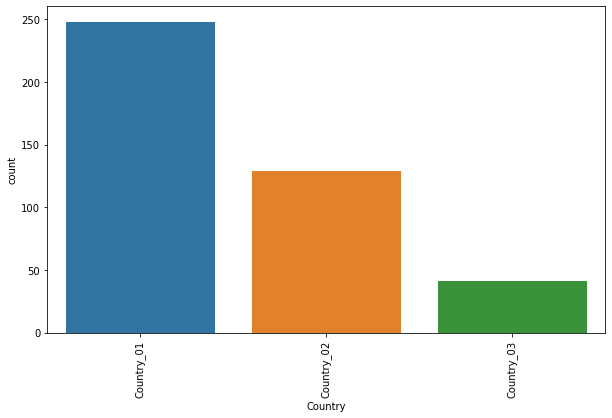

-----------------
Pie Chart for feature:  Country
------------------


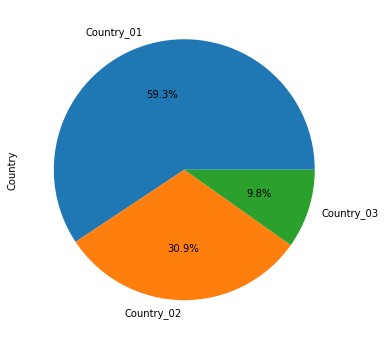



-----------------
Value Counts for feature:  Country
-------------------
Country_01    248
Country_02    129
Country_03     41
Name: Country, dtype: int64





You: give me the details of accident and country




Data Analysis of features:  Accident Level  and   Country


------------------------------------------
Cross table Analysis of features:  Accident Level  and   Country
------------------------------------------


Country,Country_01,Country_02,Country_03
Accident Level,,,
I,177,98,34
II,19,19,2
III,21,7,3
IV,23,5,2
V,8,0,0




------------------------------------------
Count plot Analysis of features:  Accident Level  and   Country
------------------------------------------


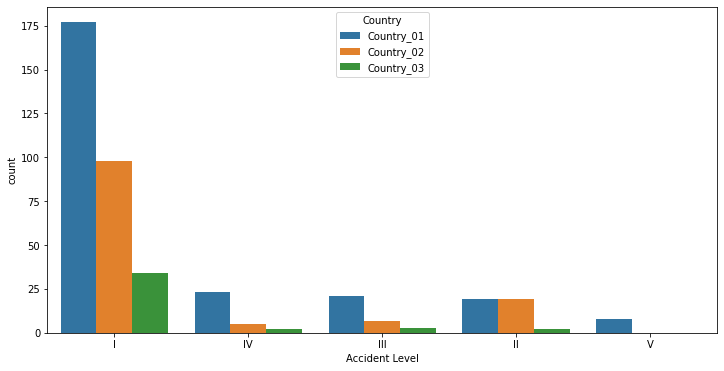





You: tell me about local


What type of detail do you want to see for Local : 'Univariate analysis for Local' or 'bivariate analysis for accident and local' 




You: Univariate analysis for Local




Data Analysis of feature:  Local



-----------------
Countplot  for feature:  Local
-----------------


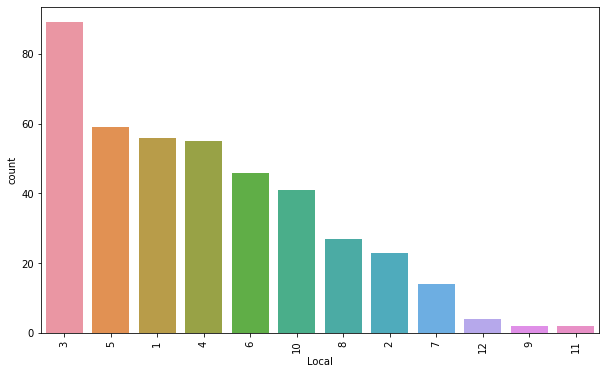

-----------------
Pie Chart for feature:  Local
------------------


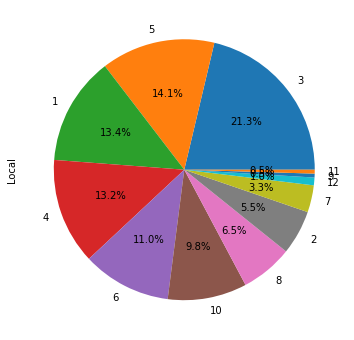



-----------------
Value Counts for feature:  Local
-------------------
3     89
5     59
1     56
4     55
6     46
10    41
8     27
2     23
7     14
12     4
9      2
11     2
Name: Local, dtype: int64





You: bye


BOT: Exited from Data Insights Module


-----------------------------------------------------



BOT: Please Select appropriate option:               
 	                
 	 1 --> For Question and Answers               
 	 2 --> For finding the Accident level for your problem               
 	 3 --> For finding the Potential Accident level for your problem               
 	 4 --> For Historical Data Insights               
 	                
 	 if you want to exit any time, just type Bye!


You: exit


BOT: Goodbye! Take care  






In [87]:
chatbot_main()